In [1]:
import os
import sys
import argparse
from typing import Tuple
from tensorboardX import SummaryWriter
import copy
import time
import math
import numpy as np
import pickle

# Progressbar
from tqdm import tqdm

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Highlevel from Pytorch
import torch as T
from torch import nn, Tensor
import torch.optim as opt

# Neural Network parts from Pytorch
from torch.nn import TransformerEncoder, TransformerEncoderLayer, init
import torch.nn.functional as F

# Pytorch's Dataset and Dataloader
from torch.utils.data import dataset
from torch.utils.data import DataLoader

# Dataset used
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

# Custom Libraries
import utils
import transformer_modell

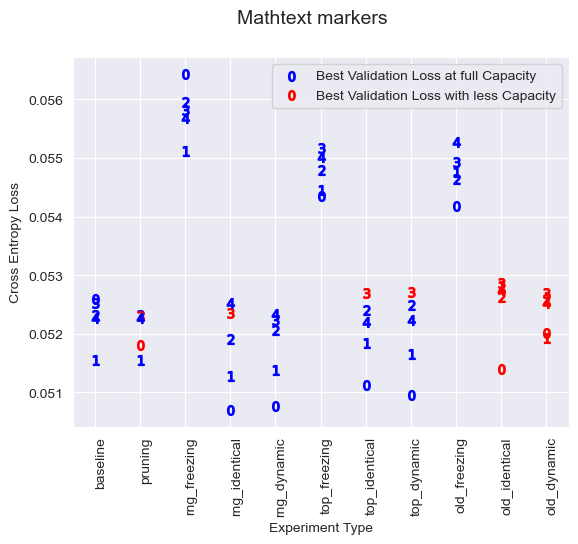

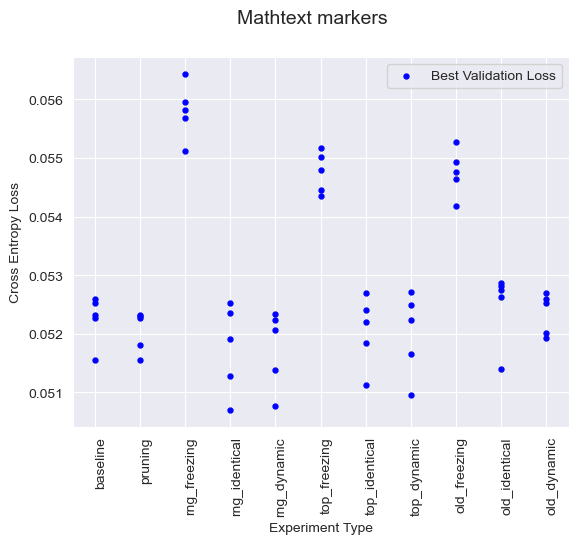

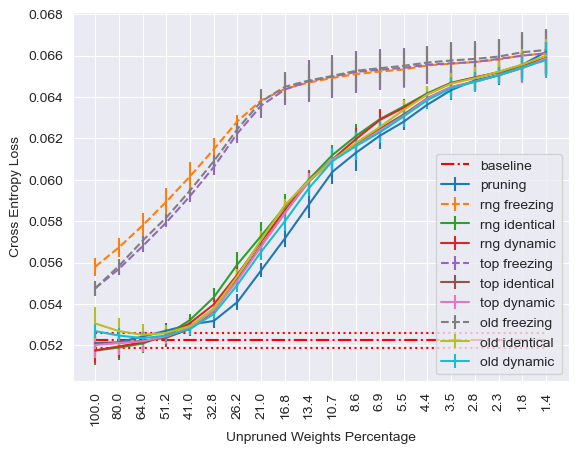

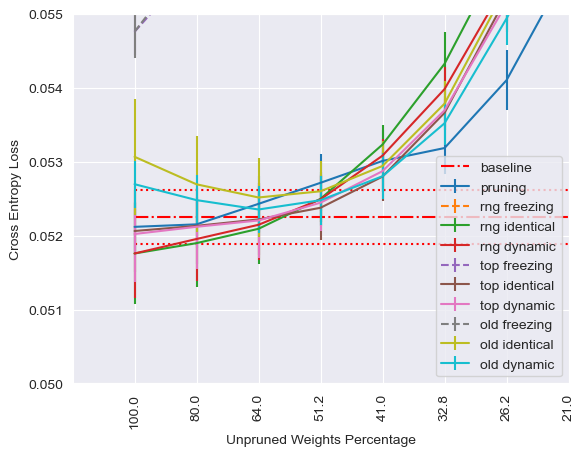

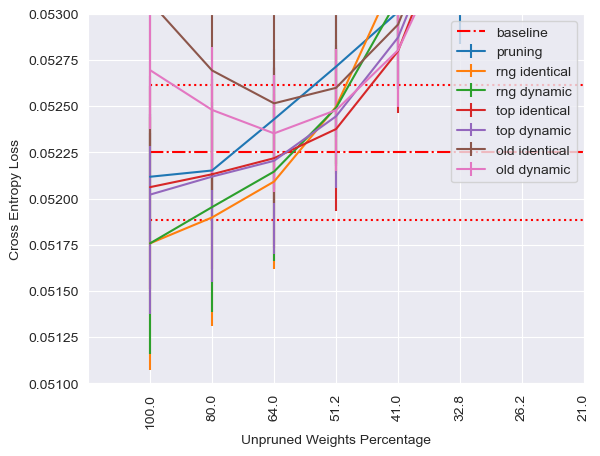

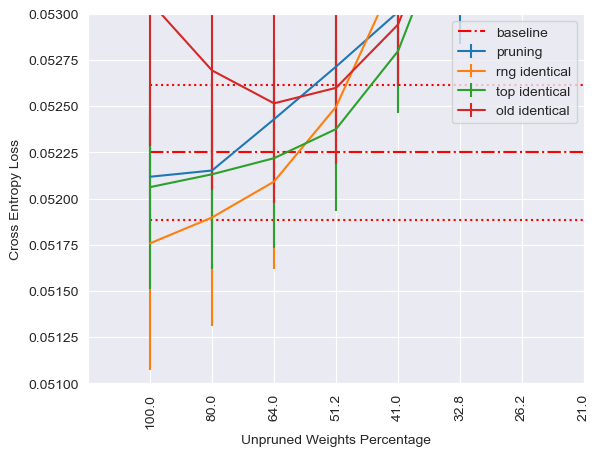

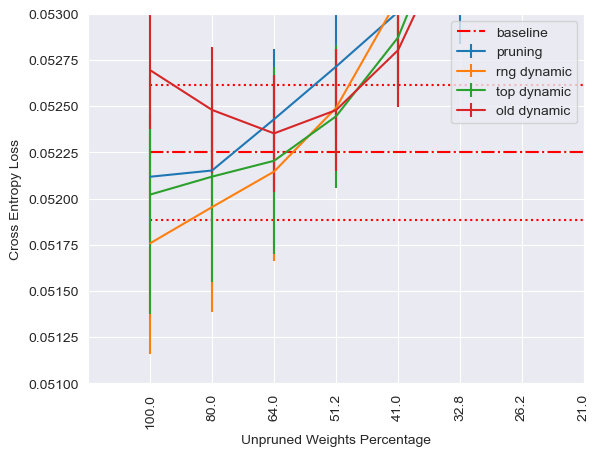

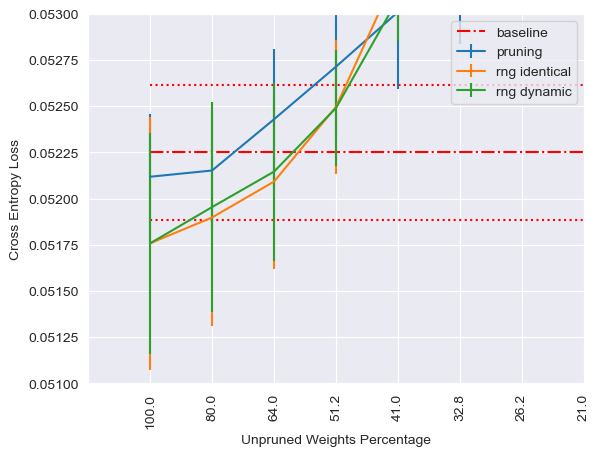

In [3]:
utils.my_plotter("runs_scattered_best_last", ["baseline", "pruning", "reintroduction"], ["rng", "top", "old"],
                 ["freezing", "identical", "dynamic"], markers="num")
utils.my_plotter("runs_scattered_best", ["baseline", "pruning", "reintroduction"], ["rng", "top", "old"],
                 ["freezing", "identical", "dynamic"])

utils.my_plotter("mean_var_graph", ["baseline", "pruning", "reintroduction"], ["rng", "top", "old"],
                 ["freezing", "identical", "dynamic"])
utils.my_plotter("mean_var_graph", ["baseline", "pruning", "reintroduction"], ["rng", "top", "old"],
                 ["freezing", "identical", "dynamic"], zoom=True)
utils.my_plotter("mean_var_graph", ["baseline", "pruning", "reintroduction"], ["rng", "top", "old"],
                 ["identical", "dynamic"], zoom=True, ylim=[0.051, 0.053])
utils.my_plotter("mean_var_graph", ["baseline", "pruning", "reintroduction"], ["rng", "top", "old"], ["identical"],
                 zoom=True, ylim=[0.051, 0.053])
utils.my_plotter("mean_var_graph", ["baseline", "pruning", "reintroduction"], ["rng", "top", "old"], ["dynamic"],
                 zoom=True, ylim=[0.051, 0.053])
utils.my_plotter("mean_var_graph", ["baseline", "pruning", "reintroduction"], ["rng"], ["identical","dynamic"],
                 zoom=True, ylim=[0.051, 0.053])


In [81]:
all_train_loss_prune = np.array([])
all_train_loss_reint = np.array([])
with open(f"{os.getcwd()}/pruning/0/dumps/summary_plot_data/compression.dat", "rb") as input_file:
    comp = pickle.load(input_file)
for _c in comp:
    with open(f"{os.getcwd()}/pruning/0/dumps/train_loss/all_train_loss_{_c}.dat", "rb") as input_file:
        all_train_loss_prune_temp   = pickle.load(input_file)
    all_train_loss_prune = np.concatenate((all_train_loss_prune, all_train_loss_prune_temp))
with open(f"{os.getcwd()}/reintroduction/old_identical/0/dumps/reint_summary_plot_data/compression.dat", "rb") as input_file:
    comp_reint = pickle.load(input_file)
for c in comp_reint:
    with open(f"{os.getcwd()}/reintroduction/old_identical/0/dumps/train_loss_reint/all_train_loss_{c}.dat", "rb") as input_file:
        all_train_loss_reint_temp   = pickle.load(input_file)
    all_train_loss_reint = np.concatenate((all_train_loss_reint, all_train_loss_reint_temp))


all_val_loss_prune = np.array([])
all_val_loss_reint = np.array([])
with open(f"{os.getcwd()}/pruning/0/dumps/summary_plot_data/compression.dat", "rb") as input_file:
    comp = pickle.load(input_file)
for _c in comp:
    with open(f"{os.getcwd()}/pruning/0/dumps/validation_loss/all_val_loss_{_c}.dat", "rb") as input_file:
        all_val_loss_prune_temp   = pickle.load(input_file)
    all_val_loss_prune = np.concatenate((all_val_loss_prune, all_val_loss_prune_temp))
with open(f"{os.getcwd()}/reintroduction/old_identical/0/dumps/reint_summary_plot_data/compression.dat", "rb") as input_file:
    comp_reint = pickle.load(input_file)
for c in comp_reint:
    with open(f"{os.getcwd()}/reintroduction/old_identical/0/dumps/validation_loss_reint/all_val_loss_{c}.dat", "rb") as input_file:
        all_val_loss_reint_temp   = pickle.load(input_file)
    all_val_loss_reint = np.concatenate((all_val_loss_reint, all_val_loss_reint_temp))

all_train_loss = np.concatenate((all_train_loss_prune,all_train_loss_reint))
all_val_loss = np.concatenate((all_val_loss_prune,all_val_loss_reint))

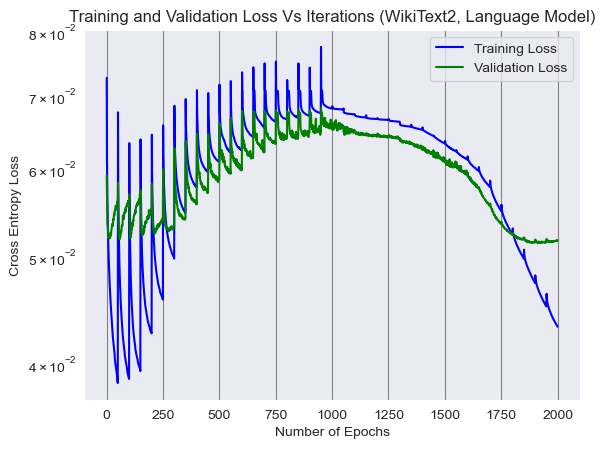

In [86]:
plt.plot(np.arange(1, 2001), all_train_loss, c="b", label="Training Loss")
plt.plot(np.arange(1, 2001), all_val_loss, c="g", label="Validation Loss")
plt.yscale('log')
plt.title(f"Training and Validation Loss Vs Iterations (WikiText2, Language Model)")
plt.xlabel("Number of Epochs")
plt.ylabel("Cross Entropy Loss")
plt.legend()
plt.grid(color="gray")

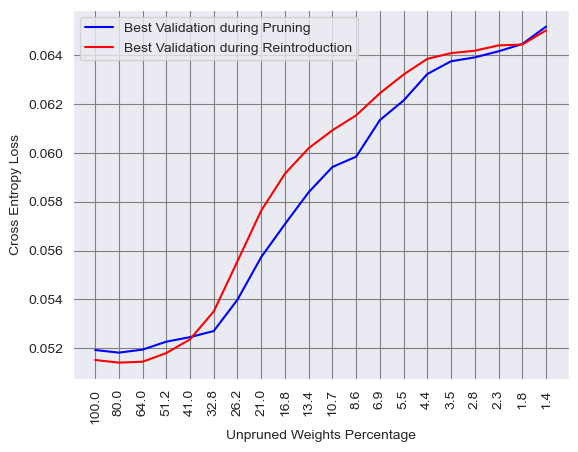

In [77]:
with open(f"{os.getcwd()}/pruning/0/dumps/summary_plot_data/best_val.dat", "rb") as input_file:
    best_val = pickle.load(input_file)
with open(f"{os.getcwd()}/reintroduction/old_identical/0/dumps/reint_summary_plot_data/best_val.dat", "rb") as input_file:
    best_val_reint = pickle.load(input_file)
    best_val_reint = np.flip(best_val_reint)
with open(f"{os.getcwd()}/pruning/0/dumps/summary_plot_data/compression.dat", "rb") as input_file:
    comp = pickle.load(input_file)
a = range(20)
plt.plot(a, best_val, c="b", label="Best Validation during Pruning")
plt.plot(a, best_val_reint, c="r", label="Best Validation during Reintroduction")
plt.xlabel("Unpruned Weights Percentage")
plt.ylabel("Cross Entropy Loss")
plt.xticks(a, comp, rotation="vertical")
plt.legend()
plt.grid(color="gray")

In [78]:
train_loss_all = np.array([])
for i in range(40):
    with open(f"{os.getcwd()}/baseline/1/dumps/train_loss/all_train_loss_{i}.dat", "rb") as input_file:
        temp   = pickle.load(input_file)
    train_loss_all = np.concatenate((train_loss_all,temp))
train_loss_all = train_loss_all

In [79]:
val_loss_all = np.array([])
for i in range(40):
    with open(f"{os.getcwd()}/baseline/1/dumps/validation_loss/all_val_loss_{i}.dat", "rb") as input_file:
        temp   = pickle.load(input_file)
    val_loss_all = np.concatenate((val_loss_all,temp))
val_loss_all = val_loss_all

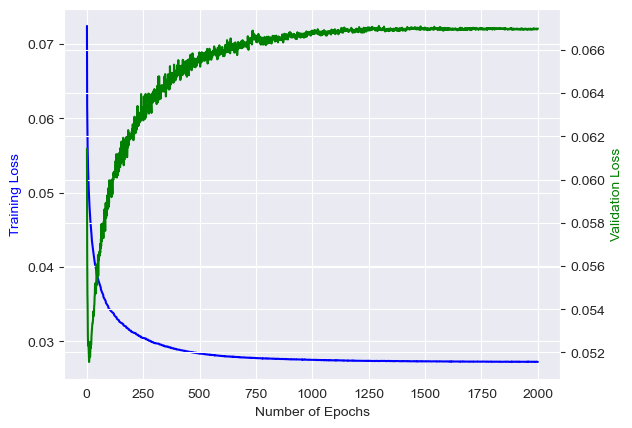

In [80]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(np.arange(1, 2001), train_loss_all, c="b", label="Train Loss")
ax2.plot(np.arange(1, 2001), val_loss_all, c="g", label="Validation Loss")

ax1.set_xlabel("Number of Epochs")
ax1.set_ylabel("Training Loss", c="b")
ax2.set_ylabel("Validation Loss", c="g")

plt.show()

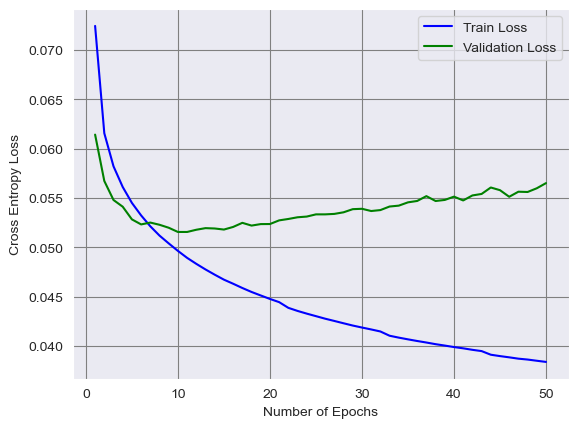

In [6]:
plt.plot(np.arange(1, 51), train_loss_all[:50], c="b", label="Train Loss")
plt.plot(np.arange(1, 51), val_loss_all[:50], c="g", label="Validation Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Cross Entropy Loss")
plt.legend()
plt.grid(color="gray")

In [75]:
with open(f"{os.getcwd()}/baseline/1/dumps/summary_plot_data/best_val.dat","rb") as input_file:
    val_loss_checkpoint = pickle.load(input_file)
val_loss_checkpoint = val_loss_checkpoint
best_checkpoint = val_loss_checkpoint.min()

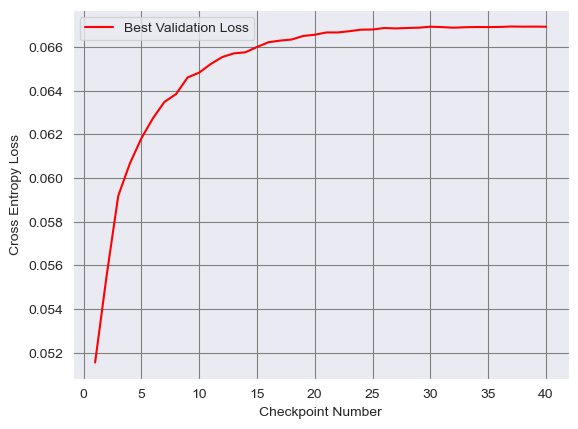

In [76]:
plt.plot(np.arange(1, 41), val_loss_checkpoint, c="r", label="Best Validation Loss")
plt.xlabel("Checkpoint Number")
plt.ylabel("Cross Entropy Loss")
#plt.yscale("log")
plt.legend()
plt.grid(color="gray")

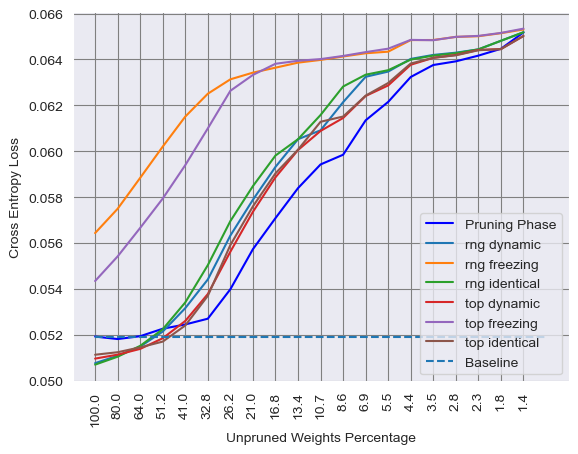

In [4]:
with open(f"{os.getcwd()}/pruning/0/dumps/summary_plot_data/best_val.dat", "rb") as input_file:
    best_val = pickle.load(input_file)
with open(f"{os.getcwd()}/pruning/0/dumps/summary_plot_data/compression.dat", "rb") as input_file:
    comp = pickle.load(input_file)
best_checkpoint = best_val[0]
a = range(20)
plt.plot(a, best_val, c="b", label="Pruning Phase")
choice    = ["rng", "top"]
variation = ["dynamic", "freezing", "identical"]
val_reint = np.full((9,20), np.inf)
i = 0
for c in choice:
    for v in variation:
        with open(f"{os.getcwd()}/reintroduction/{c+'_'+v}/0/dumps/reint_summary_plot_data/best_val.dat", "rb") as input_file:
            v_r          = pickle.load(input_file)
            val_reint[i] = np.flip(v_r)
            i += 1
        plt.plot(a, val_reint[i-1], label=f"{c} {v}")
plt.hlines(y=best_checkpoint, xmin=0, xmax=20, ls='--', label="Baseline")
plt.xlabel("Unpruned Weights Percentage")
plt.ylabel("Cross Entropy Loss")
plt.xticks(a, comp, rotation="vertical")
plt.legend()
plt.grid(color="gray")

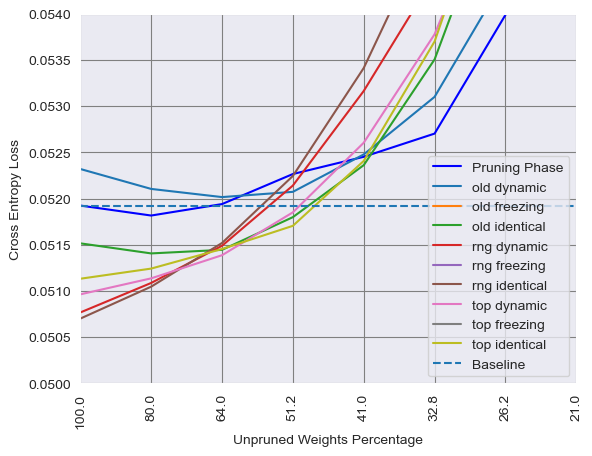

In [74]:
with open(f"{os.getcwd()}/pruning/0/dumps/summary_plot_data/best_val.dat", "rb") as input_file:
    best_val = pickle.load(input_file)
with open(f"{os.getcwd()}/pruning/0/dumps/summary_plot_data/compression.dat", "rb") as input_file:
    comp = pickle.load(input_file)
best_checkpoint = best_val[0]
a = range(20)
i = 0
plt.plot(a, best_val, c="b", label="Pruning Phase")
for c in choice:
    for v in variation:
        plt.plot(a, val_reint[i], label=f"{c} {v}")
        i += 1
plt.hlines(y=best_checkpoint, xmin=0, xmax=20, ls='--', label="Baseline")
plt.ylim(0.050, 0.054)
plt.xlabel("Unpruned Weights Percentage")
plt.ylabel("Cross Entropy Loss")
plt.xticks(a, comp, rotation="vertical")
plt.xlim(0,7)
plt.legend()
plt.grid(color="gray")

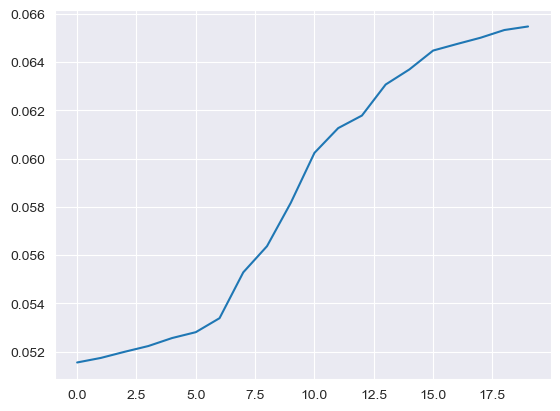

In [87]:
PATH = f"{os.getcwd()}/pruning/1/dumps/summary_plot_data/best_val.dat"
with open(PATH, "rb") as input_file:
    val = pickle.load(input_file)
#val.dump(PATH)
plt.plot(range(20),val)

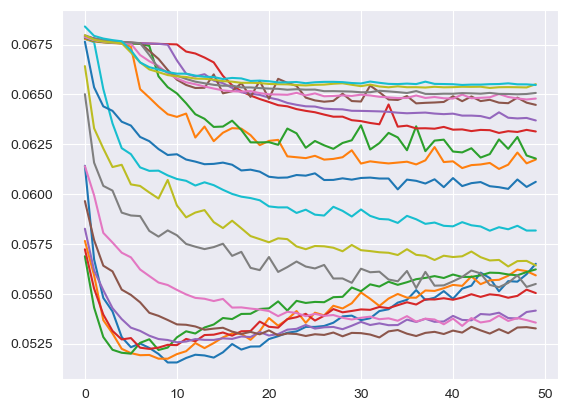

In [88]:
with open(f"{os.getcwd()}/pruning/1/dumps/summary_plot_data/compression.dat", "rb") as input_file:
    comp = pickle.load(input_file)
for c in comp:
    PATH = f"{os.getcwd()}/pruning/1/dumps/validation_loss/all_val_loss_{c}.dat"
    with open(PATH, "rb") as input_file:
        val = pickle.load(input_file)
#    val.dump(PATH)
    plt.plot(range(50),val)

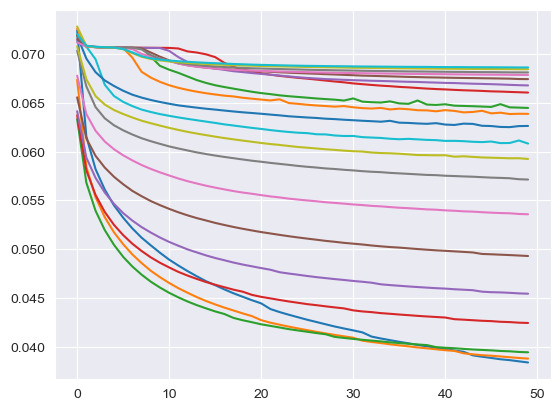

In [90]:
with open(f"{os.getcwd()}/pruning/1/dumps/summary_plot_data/compression.dat", "rb") as input_file:
    comp = pickle.load(input_file)
for c in comp:
    PATH = f"{os.getcwd()}/pruning/1/dumps/train_loss/all_train_loss_{c}.dat"
    with open(PATH, "rb") as input_file:
        train = pickle.load(input_file)
#    train.dump(PATH)
    plt.plot(range(50), train)

In [9]:
train_iter, test_iter, val_iter = WikiText2.iters(batch_size=1)
with open(f"{os.getcwd()}/reintroduction/rng_identical/0/dumps/reint_summary_plot_data/best_val.dat", "rb") as input_file:
    rng_identical_val = pickle.load(input_file)
best_rng_identical_val = rng_identical_val.min()
print(2**(best_rng_identical_val*len(val_iter)))

The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.
The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.
The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.


1.2548039632547496e+107


In [3]:
test_string1 = "small_medium_decoder"
test_string2 = "medium_decoder"
print(test_string2 in test_string1)

True


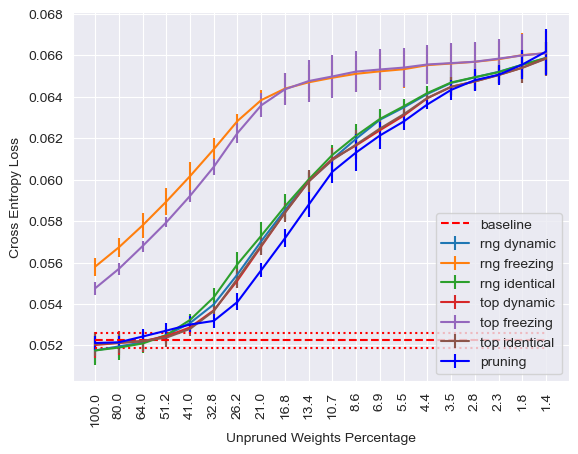

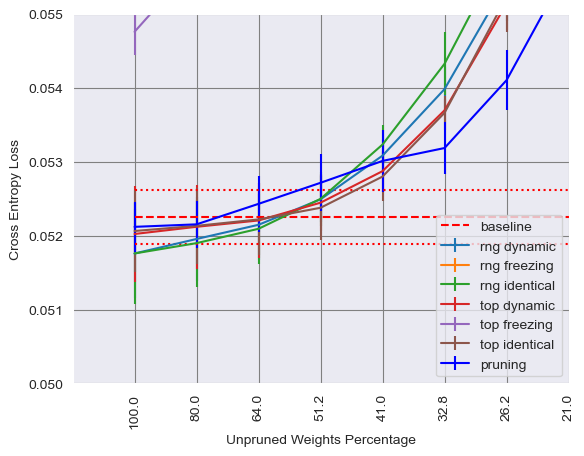

In [46]:
choice    = ["rng", "top"]
variation = ["dynamic", "freezing", "identical"]
for c in choice:
    for v in variation:
        v_r = np.full((5,20), np.inf)
        for i in range(5):
            with open(f"{os.getcwd()}/reintroduction/{c+'_'+v}/{i}/dumps/reint_summary_plot_data/best_val.dat", "rb") as input_file:
                v_r[i]   = np.flip(pickle.load(input_file))
        v_r_mean = v_r.mean(axis=0)
        v_r_std  = v_r.std(axis=0)
        plt.errorbar(a, v_r_mean,v_r_std, label=f"{c} {v}")
v_r = np.full((5,20), np.inf)
for i in range(5):
    with open(f"{os.getcwd()}/pruning/{i}/dumps/summary_plot_data/best_val.dat", "rb") as input_file:
        v_r[i] = pickle.load(input_file)
v_r_mean = v_r.mean(axis=0)
v_r_std  = v_r.std(axis=0)
plt.errorbar(a, v_r_mean,v_r_std,c="b", label=f"pruning")

bl = np.full((5,), np.inf)
for i in range(5):
    with open(f"{os.getcwd()}/baseline/{i}/dumps/summary_plot_data/best_val.dat", "rb") as input_file:
        bl[i] = (pickle.load(input_file)).min()
bl_mean = bl.mean(axis=0)
bl_std  = bl.std(axis=0)
plt.hlines(bl_mean,xmin=0, xmax=19,color="r",ls="--", label=f"baseline")
plt.hlines(bl_mean+bl_std,xmin=0, xmax=19,color="r",ls=":")
plt.hlines(bl_mean-bl_std,xmin=0, xmax=19,color="r",ls=":")
with open(f"{os.getcwd()}/pruning/0/dumps/summary_plot_data/compression.dat", "rb") as input_file:
    comp = pickle.load(input_file)
#plt.hlines(y=best_checkpoint, xmin=0, xmax=20, ls='--', label="Baseline")
plt.xlabel("Unpruned Weights Percentage")
plt.ylabel("Cross Entropy Loss")
plt.xticks(a, comp, rotation="vertical")
plt.legend()
#plt.grid(color="gray")
plt.show()
for c in choice:
    for v in variation:
        v_r = np.full((5,20), np.inf)
        for i in range(5):
            with open(f"{os.getcwd()}/reintroduction/{c+'_'+v}/{i}/dumps/reint_summary_plot_data/best_val.dat", "rb") as input_file:
                v_r[i]   = np.flip(pickle.load(input_file))
        v_r_mean = v_r.mean(axis=0)
        v_r_std  = v_r.std(axis=0)
        plt.errorbar(a, v_r_mean,v_r_std, label=f"{c} {v}")
v_r = np.full((5,20), np.inf)
for i in range(5):
    with open(f"{os.getcwd()}/pruning/{i}/dumps/summary_plot_data/best_val.dat", "rb") as input_file:
        v_r[i] = pickle.load(input_file)
v_r_mean = v_r.mean(axis=0)
v_r_std  = v_r.std(axis=0)
plt.errorbar(a, v_r_mean,v_r_std,c="b", label=f"pruning")

bl = np.full((5,), np.inf)
for i in range(5):
    with open(f"{os.getcwd()}/baseline/{i}/dumps/summary_plot_data/best_val.dat", "rb") as input_file:
        bl[i] = (pickle.load(input_file)).min()
bl_mean = bl.mean(axis=0)
bl_std  = bl.std(axis=0)
plt.hlines(bl_mean,xmin=0, xmax=19,color="r",ls="--", label=f"baseline")
plt.hlines(bl_mean+bl_std,xmin=0, xmax=19,color="r",ls=":")
plt.hlines(bl_mean-bl_std,xmin=0, xmax=19,color="r",ls=":")
with open(f"{os.getcwd()}/pruning/0/dumps/summary_plot_data/compression.dat", "rb") as input_file:
    comp = pickle.load(input_file)
plt.xlabel("Unpruned Weights Percentage")
plt.ylabel("Cross Entropy Loss")
plt.xticks(a, comp, rotation="vertical")
plt.ylim(0.050, 0.055)
plt.xlim(-1,7)
plt.legend()
plt.grid(color="gray")

In [ ]:
def my_plotter(styles: list, choice: list, variation: list, number: int = 5, zoom: bool = False, ls=None) -> None:
    """
    Inputs:
        styles: can be subset from ["baseline", "pruning", "reintroduction"]
        choice: iff style == reintroduction then it can be any subset from ["old","rng","top"]
        variation: iff style == reintroduction then it can be any subset from ["freezing","identical","dynamic"]
        number: can be any integer up to 5
        zoom: zooms in on fixed area of the plot
    """
    if ls is None:
        ls = {"freezing": "--", "dynamic": "-", "identical": "-", "pruning": "-", "baseline1": "-.", "baseline2": ":"}
    for style in styles:
        if style == "reintroduction":
            for c in choice:
                for v in variation:
                    c_v_val = np.full((number, 20), np.inf)
                    for i in range(number):
                        with open(f"{os.getcwd()}/{style}/{c + '_' + v}/{i}/dumps/reint_summary_plot_data/best_val.dat",
                                  "rb") as input_file:
                            c_v_val[i] = np.flip(pickle.load(input_file))
                    c_v_val_mean = c_v_val.mean(axis=0)
                    c_v_val_std = c_v_val.std(axis=0)
                    plt.errorbar(range(20), c_v_val_mean, c_v_val_std, ls=ls.get(v), label=f"{c} {v}")
        elif style == "pruning":
            s_val = np.full((number, 20), np.inf)
            for i in range(number):
                with open(f"{os.getcwd()}/{style}/{i}/dumps/summary_plot_data/best_val.dat", "rb") as input_file:
                    s_val[i] = pickle.load(input_file)
            s_val_mean = s_val.mean(axis=0)
            s_val_std = s_val.std(axis=0)
            plt.errorbar(range(20), s_val_mean, s_val_std, ls=ls.get(style), label=f"{style}")
        elif style == "baseline":
            s_val = np.full((number,), np.inf)
            for i in range(number):
                with open(f"{os.getcwd()}/{style}/{i}/dumps/summary_plot_data/best_val.dat", "rb") as input_file:
                    s_val[i] = pickle.load(input_file).min()
            s_val_mean = s_val.mean(axis=0)
            s_val_std = s_val.std(axis=0)
            plt.hlines(s_val_mean, xmin=0, xmax=19, color="r", ls=ls.get(f"{style}1"), label=f"baseline")
            plt.hlines(s_val_mean + s_val_std, xmin=0, xmax=19, color="r", ls=ls.get(f"{style}2"))
            plt.hlines(s_val_mean - s_val_std, xmin=0, xmax=19, color="r", ls=ls.get(f"{style}2"))
        else:
            print(f"This style is unknown.")
            pass
    with open(f"{os.getcwd()}/pruning/0/dumps/summary_plot_data/compression.dat", "rb") as input_file:
        comp = pickle.load(input_file)
    plt.xlabel("Unpruned Weights Percentage")
    plt.ylabel("Cross Entropy Loss")
    plt.xticks(range(20), comp, rotation="vertical")
    if zoom:
        plt.ylim(0.050, 0.055)
        plt.xlim(-1, 7)
    plt.legend()
    #plt.grid(color="gray")
    plt.show()
    pass